## Imports

In [1]:
! pip install matplotlib

In [2]:
# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
# Torch
import os
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import datasets
import torch.optim as optim
from torchvision.transforms import ToTensor, Compose, Normalize, transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

In [3]:
# Use GPU if available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## DataLoaders and datasets + Preprocessing to standardize image size

In [4]:
# Resize the image and do a center crop, and store them on a tensor
img_size = (224, 224)
batch_size=32
train_data_dir = '/home/jovyan/BrainTumour/Training'
test_data_dir = '/home/jovyan/BrainTumour/Testing'

#preprocessing : standardizing the sizes 
#datsets and dataloaders
transform = transforms.Compose([transforms.Resize(img_size), transforms.ToTensor()])
train_dataset = datasets.ImageFolder(train_data_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_data_dir,transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = 32, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 32, shuffle = False)

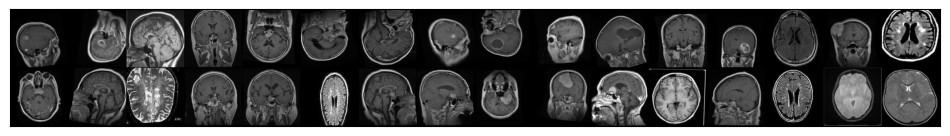

In [37]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

show_batch(train_loader)

# DenseNet

## Model Definition

In [7]:
class DenseBlock(nn.Module):
    def __init__(self, in_channels, growth_rate):
        super(DenseBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 4 * growth_rate, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(4 * growth_rate)  # BatchNorm for the first convolution
        self.conv2 = nn.Conv2d(4 * growth_rate, growth_rate, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(growth_rate)  # BatchNorm for the second convolution

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = torch.cat([x, out], 1)  # Concatenate input with output along the channels dimension
        return out


class TransitionLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransitionLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.avg_pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        out = self.avg_pool(F.relu(self.bn(self.conv(x))))
        return out

class DenseNet(nn.Module):
    def __init__(self, block, num_blocks, growth_rate=12, reduction=0.5, num_classes=4):
        super(DenseNet, self).__init__()
        self.growth_rate = growth_rate

        num_channels = 2 * growth_rate
        self.conv1 = nn.Conv2d(3, num_channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels)

        self.dense_blocks = nn.ModuleList()
        self.transition_layers = nn.ModuleList()

        for i in range(len(num_blocks) - 1):
            self.dense_blocks.append(self._make_dense_block(block, num_channels, num_blocks[i]))
            num_channels += num_blocks[i] * growth_rate
            out_channels = int(num_channels * reduction)
            self.transition_layers.append(TransitionLayer(num_channels, out_channels))
            num_channels = out_channels

        self.dense_blocks.append(self._make_dense_block(block, num_channels, num_blocks[-1]))
        num_channels += num_blocks[-1] * growth_rate

        self.bn = nn.BatchNorm2d(num_channels)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_channels, num_classes)

    def _make_dense_block(self, block, in_channels, num_blocks):
        layers = []
        for _ in range(num_blocks):
            layers.append(block(in_channels, self.growth_rate))
            in_channels += self.growth_rate
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        for i in range(len(self.dense_blocks)):
            out = self.dense_blocks[i](out)
            if i < len(self.transition_layers):
                out = self.transition_layers[i](out)

        out = self.bn(out)
        out = F.relu(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out


## Trainer Code

In [8]:
def train(model, train_loader, test_loader, training_name, saved_weights_dir, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for batch_number, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print(f'Epoch {epoch+1}/{epochs}, Batch number: {batch_number}, Cumulated accuracy: {correct/total}')
        
        epoch_loss /= len(train_loader)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Train loss: {epoch_loss:.4f}, Train accuracy: {epoch_acc:.4f}')
        
        model.eval()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss /= len(test_loader)
        epoch_acc = correct / total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')
        savedDir = f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth'
        torch.save(model.state_dict(), savedDir)
        print(f'Saved weights to {savedDir}')
    
    return train_losses, train_accuracies, test_losses, test_accuracies


In [9]:
def plot_graph(train_acc, test_acc):
    plt.plot(range(1, len(train_acc) + 1), train_acc, label='Train Accuracy')
    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Train and Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()


In [10]:
def plot_loss_graph(train_loss, test_loss):
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss')
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train and Test Loss vs. Epochs')
    plt.legend()
    plt.show()

## Tester Code

In [11]:
#loads weights, run against all test and train for all epochs to recreate loss and accuracy graph
def load_weights_and_test(model,test_loader,epochs,training_name,saved_weights_dir):
    criterion = nn.CrossEntropyLoss()    
    # recreate test
    test_losses = []
    test_accuracies = []
    
    
    for epoch in range(epochs):
        print(epoch)
        path_model_params=f'{saved_weights_dir}/{training_name}_epoch_{epoch}.pth' #edit this accordingly to folder
        model.load_state_dict(torch.load(path_model_params))
        model.eval()
        # Initialize epoch loss and accuracy
        epoch_loss = 0.0
        correct = 0
        total = 0
        # Iterate over test data
        for inputs, labels in test_loader:
            # Get from dataloader and send to device
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute model output and loss
            # (No grad computation here, as it is the test data)
            with torch.no_grad():
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
            # Accumulate loss and correct predictions for epoch
            epoch_loss += loss.item()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        # Calculate epoch loss and accuracy
        epoch_loss /= len(test_loader)
        epoch_acc = correct/total
        test_losses.append(epoch_loss)
        test_accuracies.append(epoch_acc)
        print(f'--- Epoch {epoch+1}/{epochs}: Test loss: {epoch_loss:.4f}, Test accuracy: {epoch_acc:.4f}')    
    return test_losses, test_accuracies

In [12]:
def plot_test_graph( test_acc):

    plt.plot(range(1, len(test_acc) + 1), test_acc, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Test Accuracy vs. Epochs')
    plt.legend()
    plt.show()

In [13]:
def plot_test_loss_graph(test_loss):
    
    plt.plot(range(1, len(test_loss) + 1), test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(' Test Loss vs. Epochs')
    plt.legend()
    plt.show()

# Running Models

In [45]:
# Instantiate DenseNet model
model = DenseNet(block=DenseBlock, num_blocks=[3, 3, 3], growth_rate=8, reduction=0.5, num_classes=4).to(device)
print(model)
training_name="DenseNet1"
saved_weights_dir="/home/jovyan/DenseNet_weights"
max_epochs=15


DenseNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): DenseBlock(
        (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): DenseBlock(
        (conv1): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_runn

In [46]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.359375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.4
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4479166666666667
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.48660714285714285
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.484375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4965277777777778
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.50625
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5227272727272727
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.546875
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5600961538461539
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5714285714285714
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5791666666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.587890625
E

KeyboardInterrupt: 

0
--- Epoch 1/15: Test loss: 0.7220, Test accuracy: 0.6987
1
--- Epoch 2/15: Test loss: 0.6103, Test accuracy: 0.7704
2
--- Epoch 3/15: Test loss: 1.0160, Test accuracy: 0.6430
3
--- Epoch 4/15: Test loss: 0.5634, Test accuracy: 0.7773
4
--- Epoch 5/15: Test loss: 0.4976, Test accuracy: 0.8078
5
--- Epoch 6/15: Test loss: 0.6296, Test accuracy: 0.7658
6
--- Epoch 7/15: Test loss: 0.6161, Test accuracy: 0.7498
7
--- Epoch 8/15: Test loss: 0.4098, Test accuracy: 0.8520
8
--- Epoch 9/15: Test loss: 0.7272, Test accuracy: 0.7559
9
--- Epoch 10/15: Test loss: 0.3125, Test accuracy: 0.8802
10
--- Epoch 11/15: Test loss: 0.6584, Test accuracy: 0.7757
11
--- Epoch 12/15: Test loss: 0.9045, Test accuracy: 0.7170
12
--- Epoch 13/15: Test loss: 0.3101, Test accuracy: 0.8917
13
--- Epoch 14/15: Test loss: 0.2919, Test accuracy: 0.8963
14
--- Epoch 15/15: Test loss: 0.9293, Test accuracy: 0.7185


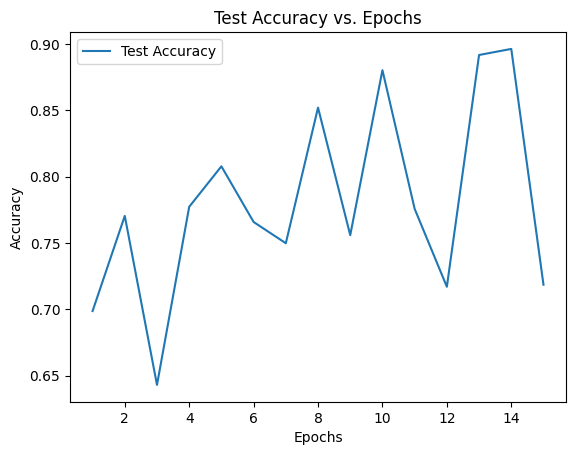

In [17]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [18]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)


max accuracy:  0.8962623951182304
epoch:  14


In [17]:
# Instantiate DenseNet model
model = DenseNet(block=DenseBlock, num_blocks=[3, 3, 3], growth_rate=12, reduction=0.5, num_classes=4).to(device)
print(model)
training_name="DenseNet2"
saved_weights_dir="/home/jovyan/DenseNet_weights"
max_epochs=15


DenseNet(
  (conv1): Conv2d(3, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): DenseBlock(
        (conv1): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): DenseBlock(
        (conv1): Conv2d(36, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(48, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.390625
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.40625
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.453125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.475
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.5052083333333334
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.5267857142857143
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.52734375
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.5381944444444444
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.528125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5426136363636364
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.5520833333333334
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5528846153846154
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5446428571428571
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5541666666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy: 

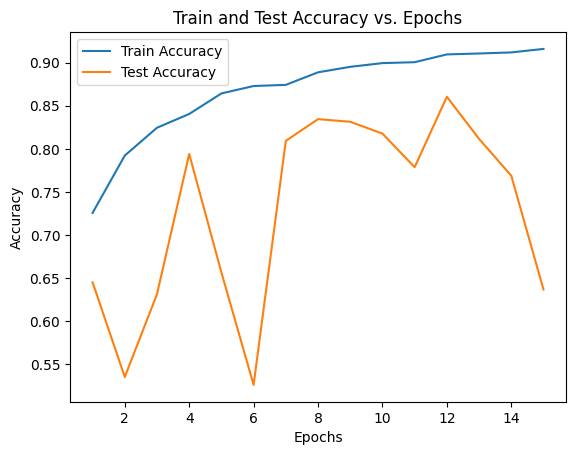

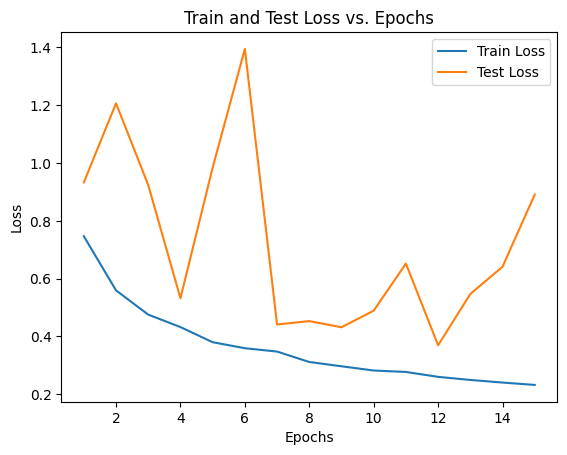

In [18]:

train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 0.9329, Test accuracy: 0.6453
1
--- Epoch 2/15: Test loss: 1.2065, Test accuracy: 0.5355
2
--- Epoch 3/15: Test loss: 0.9238, Test accuracy: 0.6316
3
--- Epoch 4/15: Test loss: 0.5321, Test accuracy: 0.7941
4
--- Epoch 5/15: Test loss: 0.9841, Test accuracy: 0.6568
5
--- Epoch 6/15: Test loss: 1.3947, Test accuracy: 0.5263
6
--- Epoch 7/15: Test loss: 0.4414, Test accuracy: 0.8093
7
--- Epoch 8/15: Test loss: 0.4532, Test accuracy: 0.8345
8
--- Epoch 9/15: Test loss: 0.4319, Test accuracy: 0.8314
9
--- Epoch 10/15: Test loss: 0.4892, Test accuracy: 0.8177
10
--- Epoch 11/15: Test loss: 0.6521, Test accuracy: 0.7788
11
--- Epoch 12/15: Test loss: 0.3695, Test accuracy: 0.8604
12
--- Epoch 13/15: Test loss: 0.5471, Test accuracy: 0.8116
13
--- Epoch 14/15: Test loss: 0.6412, Test accuracy: 0.7689
14
--- Epoch 15/15: Test loss: 0.8910, Test accuracy: 0.6369


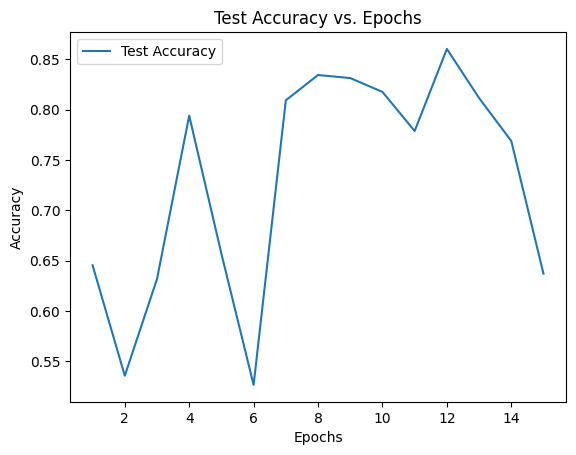

In [19]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [20]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.8604118993135011
epoch:  12


In [21]:
# Instantiate DenseNet model
model = DenseNet(block=DenseBlock, num_blocks=[3, 3, 3], growth_rate=8, reduction=0.75, num_classes=4).to(device)
print(model)
training_name="DenseNet3"
saved_weights_dir="/home/jovyan/DenseNet_weights"
max_epochs=15


DenseNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): DenseBlock(
        (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): DenseBlock(
        (conv1): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_runn

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.25
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3854166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.4453125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.45
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.453125
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.45982142857142855
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.48046875
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4965277777777778
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.5125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.5284090909090909
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.53125
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.5432692307692307
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.5580357142857143
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.5708333333333333
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.58203125
Epoc

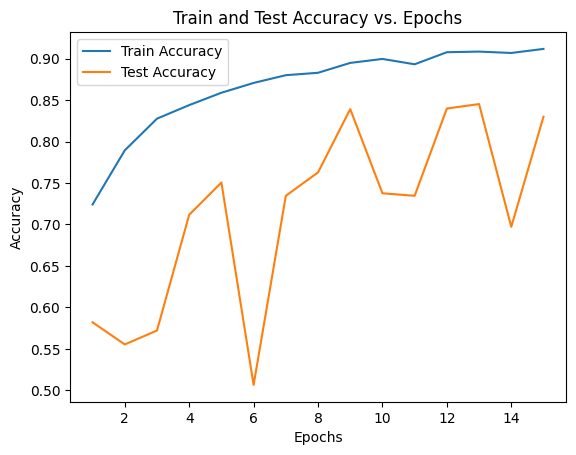

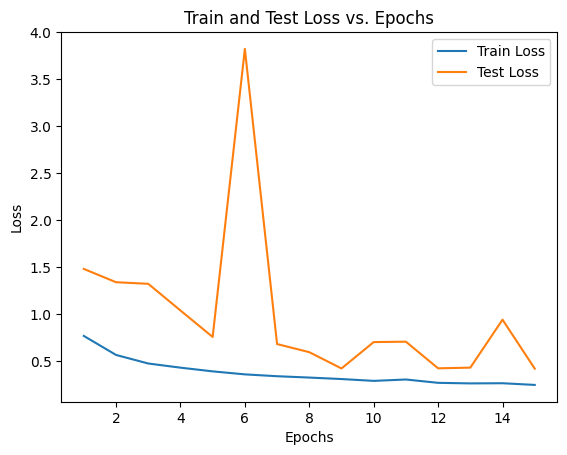

In [22]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-3)

plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 1.4807, Test accuracy: 0.5820
1
--- Epoch 2/15: Test loss: 1.3392, Test accuracy: 0.5553
2
--- Epoch 3/15: Test loss: 1.3223, Test accuracy: 0.5721
3
--- Epoch 4/15: Test loss: 1.0385, Test accuracy: 0.7117
4
--- Epoch 5/15: Test loss: 0.7566, Test accuracy: 0.7506
5
--- Epoch 6/15: Test loss: 3.8223, Test accuracy: 0.5065
6
--- Epoch 7/15: Test loss: 0.6810, Test accuracy: 0.7346
7
--- Epoch 8/15: Test loss: 0.5946, Test accuracy: 0.7628
8
--- Epoch 9/15: Test loss: 0.4212, Test accuracy: 0.8391
9
--- Epoch 10/15: Test loss: 0.7020, Test accuracy: 0.7376
10
--- Epoch 11/15: Test loss: 0.7061, Test accuracy: 0.7346
11
--- Epoch 12/15: Test loss: 0.4228, Test accuracy: 0.8398
12
--- Epoch 13/15: Test loss: 0.4300, Test accuracy: 0.8452
13
--- Epoch 14/15: Test loss: 0.9404, Test accuracy: 0.6972
14
--- Epoch 15/15: Test loss: 0.4196, Test accuracy: 0.8299


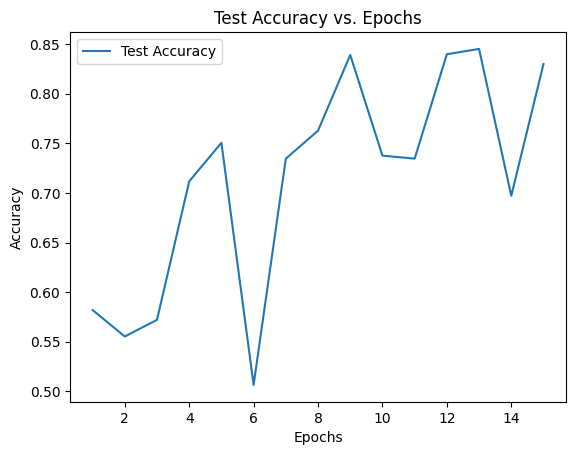

In [23]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [24]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.8451563691838292
epoch:  13


In [25]:
# Instantiate DenseNet model
model = DenseNet(block=DenseBlock, num_blocks=[4, 4, 4], growth_rate=8, reduction=0.5, num_classes=4).to(device)
print(model)
training_name="DenseNet4"
saved_weights_dir="/home/jovyan/DenseNet_weights"
max_epochs=15


DenseNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): DenseBlock(
        (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): DenseBlock(
        (conv1): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_runn

In [ ]:
train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
                                                                     train_loader, \
                                                                     test_loader, \
                                                                     training_name= training_name,\
                                                                     saved_weights_dir=saved_weights_dir,\
                                                                     epochs = max_epochs, \
                                                                     lr = 1e-4)

plot_graph(train_accuracies, test_accuracies)
plot_loss_graph(train_losses, test_losses)

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.25
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.234375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.2604166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.2875
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.2708333333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.28515625
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.28125
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.29375
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.29261363636363635
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.2994791666666667
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.2932692307692308
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.30357142857142855
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.3125
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.32421875
Epoch 1/15, 

In [ ]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [ ]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

## Model 5

In [16]:
# Instantiate DenseNet model
model = DenseNet(block=DenseBlock, num_blocks=[3, 3, 3], growth_rate=8, reduction=0.25, num_classes=4).to(device)
print(model)
training_name="DenseNet5"
saved_weights_dir="/home/jovyan/DenseNet_weights"
max_epochs=15


DenseNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dense_blocks): ModuleList(
    (0): Sequential(
      (0): DenseBlock(
        (conv1): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): DenseBlock(
        (conv1): Conv2d(24, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(32, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_runn

Epoch 1/15, Batch number: 0, Cumulated accuracy: 0.4375
Epoch 1/15, Batch number: 1, Cumulated accuracy: 0.34375
Epoch 1/15, Batch number: 2, Cumulated accuracy: 0.3854166666666667
Epoch 1/15, Batch number: 3, Cumulated accuracy: 0.3984375
Epoch 1/15, Batch number: 4, Cumulated accuracy: 0.40625
Epoch 1/15, Batch number: 5, Cumulated accuracy: 0.4270833333333333
Epoch 1/15, Batch number: 6, Cumulated accuracy: 0.4375
Epoch 1/15, Batch number: 7, Cumulated accuracy: 0.4453125
Epoch 1/15, Batch number: 8, Cumulated accuracy: 0.4305555555555556
Epoch 1/15, Batch number: 9, Cumulated accuracy: 0.43125
Epoch 1/15, Batch number: 10, Cumulated accuracy: 0.42613636363636365
Epoch 1/15, Batch number: 11, Cumulated accuracy: 0.421875
Epoch 1/15, Batch number: 12, Cumulated accuracy: 0.4254807692307692
Epoch 1/15, Batch number: 13, Cumulated accuracy: 0.42410714285714285
Epoch 1/15, Batch number: 14, Cumulated accuracy: 0.4166666666666667
Epoch 1/15, Batch number: 15, Cumulated accuracy: 0.427734

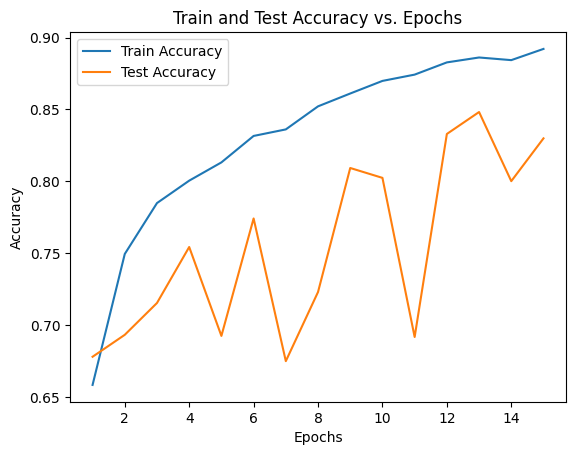

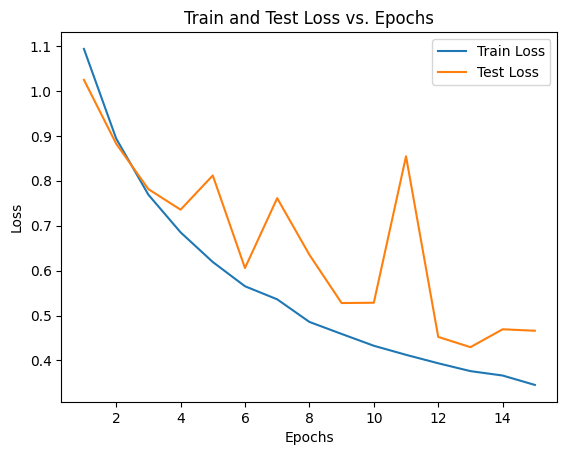

In [17]:
# train_losses, train_accuracies, test_losses, test_accuracies = train(model, \
#                                                                      train_loader, \
#                                                                      test_loader, \
#                                                                      training_name= training_name,\
#                                                                      saved_weights_dir=saved_weights_dir,\
#                                                                      epochs = max_epochs, \
#                                                                      lr = 1e-4)

# plot_graph(train_accuracies, test_accuracies)
# plot_loss_graph(train_losses, test_losses)

0
--- Epoch 1/15: Test loss: 1.0245, Test accuracy: 0.6781
1
--- Epoch 2/15: Test loss: 0.8826, Test accuracy: 0.6934
2
--- Epoch 3/15: Test loss: 0.7814, Test accuracy: 0.7155
3
--- Epoch 4/15: Test loss: 0.7357, Test accuracy: 0.7544
4
--- Epoch 5/15: Test loss: 0.8118, Test accuracy: 0.6926
5
--- Epoch 6/15: Test loss: 0.6058, Test accuracy: 0.7742
6
--- Epoch 7/15: Test loss: 0.7613, Test accuracy: 0.6751
7
--- Epoch 8/15: Test loss: 0.6353, Test accuracy: 0.7231
8
--- Epoch 9/15: Test loss: 0.5279, Test accuracy: 0.8093
9
--- Epoch 10/15: Test loss: 0.5285, Test accuracy: 0.8024
10
--- Epoch 11/15: Test loss: 0.8544, Test accuracy: 0.6918
11
--- Epoch 12/15: Test loss: 0.4524, Test accuracy: 0.8330
12
--- Epoch 13/15: Test loss: 0.4297, Test accuracy: 0.8482
13
--- Epoch 14/15: Test loss: 0.4694, Test accuracy: 0.8002
14
--- Epoch 15/15: Test loss: 0.4662, Test accuracy: 0.8299


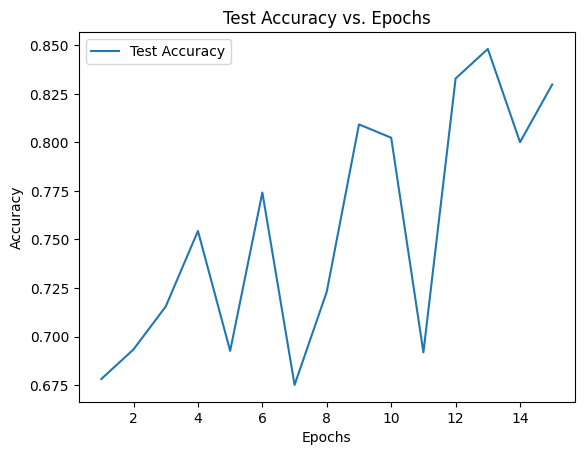

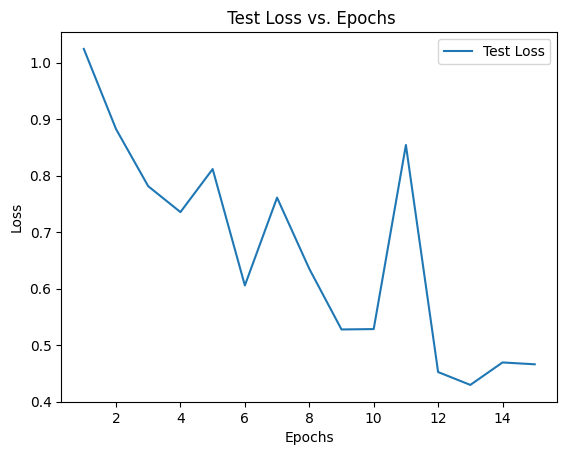

In [18]:
#run this cell to load trained weights
test_losses, test_accuracies = load_weights_and_test(model,\
                                                     test_loader,\
                                                     epochs=max_epochs,\
                                                     training_name=training_name,\
                                                     saved_weights_dir=saved_weights_dir)
plot_test_graph(test_accuracies)
plot_test_loss_graph(test_losses)

In [19]:
#finding the epoch that gives max accuracy
max_accuracy=max(test_accuracies)
epoch_num=test_accuracies.index(max_accuracy)+1
print("max accuracy: ",max_accuracy)
print("epoch: ",epoch_num)

max accuracy:  0.8482074752097636
epoch:  13
